# Predicting Customer's Credit Score

---
embed-resources: true
---

## Introduction

In this report, we develop a model where it predicts a customer's credit score based on information of each customer. This model only works on the available data we have.

## Methods

In [1]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error

# preprocessing imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor


### Data

In [2]:
# load data
import pandas as pd
credit_train = pd.read_parquet("https://cs307.org/lab/data/credit-train.parquet")
credit_test = pd.read_parquet("https://cs307.org/lab/data/credit-test.parquet")
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

credit_vtrain, credit_validation = train_test_split(
    credit_train,
    test_size=0.35,
)

credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
135,257.0,44.473,81.0,16.0,Female,No,No,None
277,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
93,388.0,16.479,26.0,16.0,Male,None,No,None
205,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
57,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
290,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
126,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
105,259.0,12.031,58.0,18.0,Female,None,Yes,Caucasian
183,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


From the train data above, each row represents a customer and their information such as their credit score, age, sex, etc. The variables in this dataset are:
### Response 

**`Rating`**

- [float64] credit rating, specifically the credit score of an individual consumer

### Features

**`Income`**

- [float64] yearly income in $1000s

**`Age`**

- [float64] age

**`Education`**

- [float64] years of education completed

**`Gender`**

- [object] gender

**`Student`**

- [object] a Yes / No variable with Yes indicating an individual is a student

**`Married`**

-[object] a Yes / No variable with Yes indicating an individual is married

**`Ethnicity`** 

- [object] ethnicity

In [3]:
# summary statistics
mean_credit = credit_train['Rating'].mean()
std_credit = credit_train['Rating'].std()
print(mean_credit, std_credit)

347.609375 148.8931046679028


We see the average credit and standard deviation of all customers in the dataset.

In [4]:
no_students = credit_train[credit_train['Student'] == 'No']
no_students_mean = no_students['Rating'].mean()
no_students_std = no_students['Rating'].std()
print(no_students_mean, no_students_std)
no_students

349.51173708920186 148.00352527445554


,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
135,257.0,44.473,81.0,16.0,Female,No,No,None
277,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
205,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
57,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
301,289.0,31.335,38.0,7.0,Female,No,No,None
...,...,...,...,...,...,...,...,...
0,283.0,14.891,34.0,11.0,Male,No,Yes,Caucasian
32,563.0,134.181,NaN,13.0,Female,No,No,Caucasian
257,186.0,15.629,60.0,14.0,Male,No,Yes,Asian
290,268.0,26.370,78.0,11.0,Male,No,Yes,Asian


In [5]:
yes_students = credit_train[credit_train['Student'] == 'Yes']
yes_students_mean = yes_students['Rating'].mean()
yes_students_std = yes_students['Rating'].std()
print(yes_students_mean, yes_students_std)
yes_students.reset_index()

338.4736842105263 149.1644761183859


,index,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,261,665.0,180.379,NaN,8.0,Female,Yes,Yes,Asian
1,249,134.0,22.574,43.0,13.0,Female,Yes,Yes,Caucasian
2,9,491.0,71.061,NaN,19.0,Female,Yes,Yes,African American
3,273,353.0,16.751,48.0,14.0,Male,Yes,No,Asian
4,26,289.0,42.471,44.0,12.0,Female,Yes,No,Caucasian
5,98,241.0,36.295,68.0,14.0,Female,Yes,No,African American
6,203,499.0,68.206,40.0,16.0,Female,Yes,No,African American
7,35,220.0,23.350,NaN,12.0,Female,Yes,No,Caucasian
8,46,376.0,19.531,64.0,16.0,Female,Yes,Yes,Asian
9,76,251.0,30.622,68.0,16.0,Male,Yes,No,Caucasian


These statistic show the average credit score and standard deviation of people who are students and are not students.

In [6]:
married = credit_train[credit_train['Married'] == 'Yes']
married_mean = married['Rating'].mean()
married_std = married['Rating'].std()
print(married_mean, married_std)
married

358.90506329113924 157.7979352901777


,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
277,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
57,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
137,278.0,36.355,35.0,9.0,Male,No,Yes,Asian
134,452.0,34.664,77.0,15.0,Female,No,Yes,African American
364,685.0,128.669,67.0,16.0,Male,No,Yes,Asian
...,...,...,...,...,...,...,...,...
290,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
126,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
105,259.0,12.031,58.0,18.0,Female,None,Yes,Caucasian
183,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In [7]:
not_married = credit_train[credit_train['Married'] == 'No']
not_married_mean = not_married['Rating'].mean()
not_married_std = not_married['Rating'].std()
print(not_married_mean, not_married_std)
not_married

329.3979591836735 132.03964882478107


,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
135,257.0,44.473,81.0,16.0,Female,No,No,None
93,388.0,16.479,26.0,16.0,Male,None,No,None
205,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
123,117.0,11.808,77.0,NaN,Female,None,No,African American
301,289.0,31.335,38.0,7.0,Female,No,No,None
...,...,...,...,...,...,...,...,...
279,248.0,54.319,59.0,8.0,Female,Yes,No,Caucasian
368,440.0,89.000,37.0,6.0,Female,No,No,Caucasian
362,382.0,26.162,62.0,NaN,Female,No,No,African American
115,369.0,40.442,81.0,8.0,Female,No,No,African American


These statistic show the average credit score and standard deviation of people who are married and are not married.

In [8]:
corr_1 = credit_train['Rating'].corr(credit_train['Age'])
corr_2 = credit_train['Rating'].corr(credit_train['Income'])
print(corr_1, corr_2)

0.1430318874061348 0.7708422040157114


In [9]:
missing_proportion = credit_train.isnull().mean()
missing_proportion

Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64

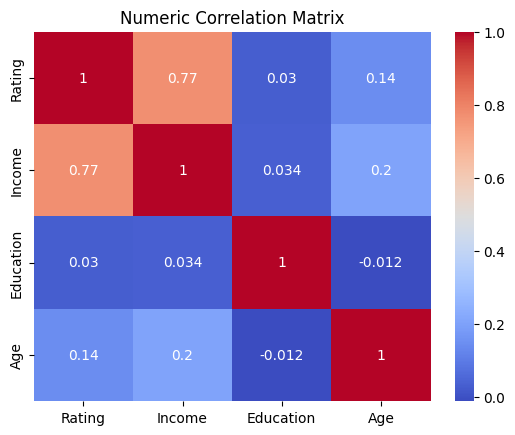

In [10]:
# exploratory visualization
numeric = ['Income', 'Education', 'Age']
numeric_corr_matrix = credit_train[['Rating', 'Income', 'Education', 'Age']].corr()
sns.heatmap(numeric_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Numeric Correlation Matrix')
plt.show()

From the correlation matrix above, we see can see which numeric data has the biggest effect on customer's credit ratings. It seems like income has a strong positive correlation with a customer's rating with a correlation number of 0.77. The other features all have a very weak correlation with customers' ratings so we will not include those features into our model.

### Models

In [11]:
# process data for ML
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

#create X and y for validation
X_validation = credit_validation.drop('Rating', axis = 1)
y_validation = credit_validation['Rating']

#create x and y for validation train
X_vtrain = credit_vtrain.drop('Rating', axis = 1)
y_vtrain = credit_vtrain['Rating']

new_numeric = ['Income']
categorical = ['Student', 'Married']
features = new_numeric + categorical
target = 'Rating'

We split the data once into train and test data and split the train data again into validation train sets and validation sets to get more accurate results. We also assigned which features to use. Income us our only numeric feature since we saw the correlation it has with customers' ratings.

In [12]:
# train models
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
)

# define preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

# create general preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer, new_numeric),
    (categorical_transformer, categorical),
    remainder="drop",
)


In [13]:
RMSE_scores = []
k_val_scores = [1, 5, 10, 15, 20, 25, 50, 100]
for k in k_val_scores:
    mod = make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors=k),
    )
    mod.fit(X_vtrain, y_vtrain)
    y_pred = mod.predict(X_validation)
    RMSE_score = root_mean_squared_error(y_validation, y_pred)
    RMSE_scores.append(RMSE_score)

# get best k value
k_best = k_val_scores[np.argmin(RMSE_scores)]

# validation results
validation_results = pd.DataFrame(
    {
        "k": k_val_scores,
        "RMSE": RMSE_scores,
    }
)
print(validation_results)
print(f"")
print(k_best)

     k        RMSE
0    1  124.859477
1    5   95.839185
2   10   95.398796
3   15   99.297828
4   20  101.765783
5   25  106.032947
6   50  123.109024
7  100  137.769074

10


After fitting the model into the validation train sets, we get the best k-value to be 25 since it has the lowest RMSE score of 93.338165. This means that the average error of predictions is 93.338165 away from the actual credit score.

## Results

In [14]:
# report model metrics
final_model = make_pipeline(
    preprocessor,
    KNeighborsRegressor(n_neighbors=k_best),
)
final_model.fit(X_train, y_train)

# predict on the test data
y_test_pred = final_model.predict(X_test)

# calculate and print the test accuracy
final_RMSE = root_mean_squared_error(y_test, y_test_pred)
print(f"Final RMSE: {final_RMSE}")

Final RMSE: 98.65348527168213


When getting our best k-value to use, we fit it to the regular train data. After fitting the train data to the final model, we use the final model to predict our y_test data using the X_test data. After doing so, we get an RMSE of 98.65348527168213.

# Discussion

Our final model achieves a test RMSE score of 98.65 and accomplishes of outperforming a test RMSE of 110. The RMSE value represents the average error from the actual value. This RMSE score of 98.65 means that when our model is trying to predict a customer's credit score based on their features we decided to use, on average the predictions will be off by 98 from the actual credit score of a customer.


Even though our model was able to out perform a test RMSE of 110, we should definitely not use this model. An RMSE of 98 is awful especially when credit scores range between the values of 300 to 850. The differences between our predictions and the actual credit score are too large making our predictions way off. For example, if a customer's true credit score were to be 600, the model could predict any values between 502 and 698.


This big difference in error can lead to costly decisions for customers and the bank. An example of this can be when a customer with a true high credit score could get wrongfully denied a loan, or approve a loan to someone whose true credit score value is way lower than the predicted value.


In order to improve this model, we should have more useful data such as payment history, debt, and credit history of a customer instead of irrelevant information such as race and age. If there are extreme outliers, we should also consider removing those values if appropriate.


The regression plot below shows the relationship between customers' income and their credit score. We see a positive correlation where if an income is high, it will generally also have a high credit score. The regression line represents the line of best fit between these 2 variables and we can see a lot of variability which is not good for our model. For example, when looking at an income at $25,000, the credit score can range anywhere from 400 to 150 which is a huge difference. We would prefer to have a regression plot where the points are close to the line of best fit to reduce variability.


Overall, we should not use this model because the RMSE value of 98 is too high and could lead to costly decisions for the bank and its customers.



Text(0, 0.5, 'Credit Score')

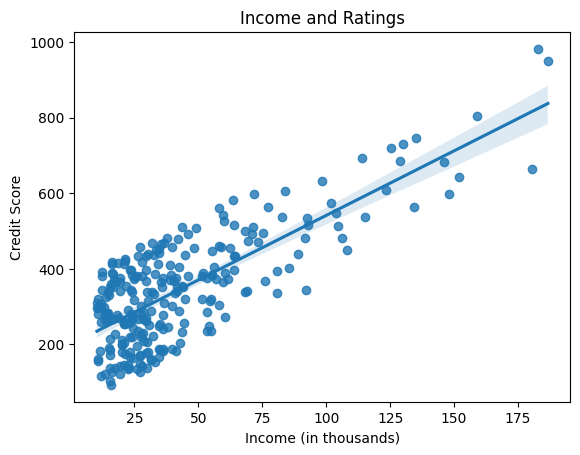

In [15]:
sns.regplot(data=credit_train, x='Income', y='Rating')
plt.title('Income and Ratings')
plt.xlabel('Income (in thousands)')
plt.ylabel('Credit Score')

In [16]:
# serialize model
from joblib import dump
dump(final_model, "credit.joblib")

['credit.joblib']